# Initialize Notebook

## Module Imports

In [138]:
################################################
#                    IMPORT                    #
################################################

import math
import random
import pandas as pd
import numpy as np
import itertools as IT

import os
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn import over_sampling


# Classification Models
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider

%config InlineBackend.figure_formats = ['retina']

import pickle

## Load Data

In [2]:
################################################
#   aisle, dept, prod indexes, merge prod dir  #
################################################

df_aisle_index = pd.read_csv('../data/instacart-market-basket-analysis/aisles.csv')
# print(df_aisle_index.shape)
df_dept_index = pd.read_csv('../data/instacart-market-basket-analysis/departments.csv')
# print(df_dept_index.shape)
df_prod_index = pd.read_csv('../data/instacart-market-basket-analysis/products.csv')
# print(df_prod_index.shape)

df_prod_dir = pd.merge(df_prod_index, df_dept_index, on='department_id')
df_prod_dir = pd.merge(df_prod_dir, df_aisle_index, on='aisle_id')

print('loaded aisle, dept, and prod indexes, and created merge product directory')


################################################
#  LOAD ORDERS LOG AND PRIOR/TRAIN ORDER-PRODS #
################################################

user_subset = range(1,501, 1)
print('generated user subset of size: ', len(user_subset))

df_orders_log = pd.DataFrame(
    columns=['order_id','user_id','eval_set','order_number',
             'order_dow','order_hour_of_day','days_since_prior_order']
)

# chunk import
def valid_user(chunks):
    for chunk in chunks:
        mask = chunk.user_id.isin(user_subset)
        yield chunk.loc[mask]
    
# read in orders
filename = '../data/instacart-market-basket-analysis/orders.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_orders_log = pd.concat(valid_user(chunks))

print('sample size for ORDERS LOG:')
print(sys.getsizeof(df_orders_log)/1000000,'MB out of total',
      os.stat('../data/instacart-market-basket-analysis/orders.csv').st_size//1000000,'MB')

# compile a list of unique orders that originate from our user sample

orders_subset = df_orders_log.order_id.unique()
print(orders_subset.shape)

def valid_order(chunks):
    for chunk in chunks:
        mask = chunk.order_id.isin(orders_subset)
        yield chunk.loc[mask]
        
df_order_prods__prior = pd.DataFrame(
    columns=['order_id','product_id','add_to_cart_order','reordered']
)

# read in order_prods_prior
filename = '../data/instacart-market-basket-analysis/order_products__prior.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_order_prods__prior = pd.concat(valid_order(chunks))

print('sample size for ORDER PROD PRIOR:')
print(sys.getsizeof(df_order_prods__prior)/1000000,'MB out of total',
      os.stat('../data/instacart-market-basket-analysis/order_products__prior.csv').st_size//1000000,'MB')
print(df_order_prods__prior.shape)

df_order_prods__train = pd.DataFrame(
    columns=['order_id','product_id','add_to_cart_order']
)

# read in order_prods_prior
filename = '../data/instacart-market-basket-analysis/order_products__train.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_order_prods__train = pd.concat(valid_order(chunks))

print('sample size for ORDER PROD TRAIN:')
print(sys.getsizeof(df_order_prods__train)/1000000,'MB out of total',
      os.stat('../data/instacart-market-basket-analysis/order_products__train.csv').st_size//1000000,'MB')
print(df_order_prods__train.shape)

loaded aisle, dept, and prod indexes, and created merge product directory
generated user subset of size:  500
sample size for ORDERS LOG:
0.960604 MB out of total 108 MB
(8142,)
sample size for ORDER PROD PRIOR:
3.097032 MB out of total 577 MB
(77425, 4)
sample size for ORDER PROD TRAIN:
0.135472 MB out of total 24 MB
(3386, 4)


# Problem Description and Ambitions

This notebook proposes a dynamic shopping cart "completer" system for deployment in the Instacart shopping interface. Users with pre-determined shopping intent should receive quality of life improvement when the cart-completer displays the next

The cart-completer panel in this instance offers a limited set of recommendations (~5) in a visible panel.

The model should be...

### 1: Agnostic to the Amount of Data

The model should be able to operate from day one, with limited observations.

### 2: Evolve Strategy as Data Quality Increases

The model will re-train at regular intervals across a stream of orders. Batches of orders represent days, at which point time-intensive re-train can take place.

## "Cart Completer" Model Evaluation Schema

A custom evaluation metric has been calculated for this purpose. The cart-completer only needs one of it's 5-10 alloted recommendation slots to contain the next item.

### Baseline Algorithm: Recommend Products By Global Popularity

As a baseline, let's create a simple algorithm that simply returns a random 5 products from the top 50 most popular products. We hope to do better than this algorithm by engineering all kinds of user- and product-specific features.

In [13]:
## NAIVE MODEL - Product Popularity Focused ##

# code to return top 50 products
# df_order_prods__prior.groupby('product_id').agg(
#     {'order_id':'nunique'}
# ).sort_values('order_id',ascending=False).index.values[:50]

class NaiveTopProducts(object):
    '''
    
    A naive product recommendation algorithm,
    based on overal product popularity.
    
    '''
    
    def __init__(self):
    
        self.type = 'naive'
    
    def fit(self, order_train):
        '''
        
        Pull top 50 products from dataframe.
        
        '''
        
        self.top100 = set(order_train.groupby('product_id').agg(
            {'order_id':'nunique'}
        ).sort_values('order_id',ascending=False).index.values[:100])
        
    def predict(self, n=5):
        
        return random.sample(self.top100, n)

In [14]:
naive_model = NaiveTopProducts()
naive_model.fit(df_order_prods__prior)
preds = naive_model.predict()

### Simulate Dynamic Product Recommendation

In [15]:
def SimulateDynamicRec(order_rows, model, verbose=False):
    
    assert type(order_rows) == type(pd.DataFrame())
    cart = set([])
    
    order_rows = order_rows.sort_values('add_to_cart_order')
    
    if verbose:
        print('testing the following order:\n', order_rows)
    
    total = 0
    guessed = 0
    
    # progress through order one at a time
    for index, row in order_rows.iterrows():
        
        ### Recommend 5 New Products ###
        
        try:
            #### CHECK MODEL TYPE #####
            model_type = model.type
#             print('model type is: ', model_type)
            if model_type in ['naive','reordered']:
                recommendations = model.top100
            
            
            # Exclude items already in cart.
            rec5 = random.sample((recommendations - cart), 5)
            
        except:
            #### OTHER MODELS #####
            pass
        
        
        total += 1
        success = False
        
        actual_next = row['product_id']
        
        if actual_next in rec5:
            success = True
            guessed += 1
        
        # debug output
        if verbose:
#             print(f'Cart is {cart}.\nRecommending {rec5}.')
            if success:
                print(f'Guessed {actual_next}!\n')
                continue
            else:
#                 print(f'Oops, {actual_next} wasn\'t in recommendation list.')
                continue
        
        cart.add(actual_next)
    
    # rel_pct = % of trials where recommendations were relevant to next purchase.
    rel_pct = guessed/total
    
    if verbose:
        print(f'Got {rel_pct}% right of {total}.')
    
    return rel_pct

In [16]:
def DynamicRecScore(model, trials = 100):

    relevancies = []
    
    unique_train_orders = set(df_order_prods__train.order_id.unique())
#     print(len(unique_train_orders))
    
    # If there aren't enough training datapoints.
    if trials > len(unique_train_orders):
        trials = len(unique_train_orders)
    
    for order_id in random.sample(unique_train_orders, trials):
        
#         test_order = df_order_prods__train.sample().order_id.values[0]

        test_order_rows = df_order_prods__train[df_order_prods__train.order_id == order_id]
        rel_pct = SimulateDynamicRec(test_order_rows, model,verbose=False)
        relevancies += [rel_pct]
        
    return np.mean(relevancies)

## Score Naive Top Products Model

Run simulation of user interactive with Naive Top Products as recommender.

In [17]:
# Simple cross validation of naive algorithm:

n_trials = 300
relevancies = []
for i in range(5):
    relevancies += [DynamicRecScore(model=naive_model, trials=n_trials)]
    
print(f'Mean dynamic suggestion relevancy score, Naive Algorithm, n={n_trials}:')
print(np.mean(relevancies))

Mean dynamic suggestion relevancy score, Naive Algorithm, n=300:
0.00937538738659981


# EDA

In [15]:
# Make a complete order-product list from prior and train, keeping all fields:
df_all_order_prods = pd.concat([df_order_prods__prior, df_order_prods__train])
df_all_order_prods = pd.merge(df_all_order_prods, df_prod_dir, on='product_id')
df_all_order_prods = pd.merge(df_all_order_prods, df_orders_log, on='order_id')
df_all_order_prods.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'department', 'aisle',
       'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order'],
      dtype='object')

Distributions of departments / aisles / products.

In [16]:
print('number of products = ', df_prod_index.shape[0])
print('number of aisles = ', df_aisle_index.shape[0])
print('number of depts = ', df_dept_index.shape[0])

number of products =  49688
number of aisles =  134
number of depts =  21


In [17]:
df_prod_dir = pd.merge(df_prod_index, df_dept_index, on='department_id')
df_prod_dir = pd.merge(df_prod_dir, df_aisle_index, on='aisle_id')

#### How many products _offered_ in each department?

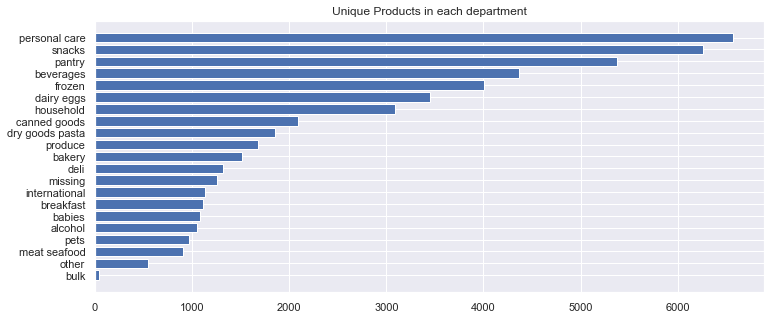

In [58]:
# Use the complete product directory for this:
data = df_prod_dir.groupby('department').product_name.nunique().sort_values()
fig = plt.figure(figsize=(12,5))
plt.barh(y=data.index, width=data.values)
plt.title("Unique Products in each department");

#### Unique Products Offered vs. Unique Products Purchased?

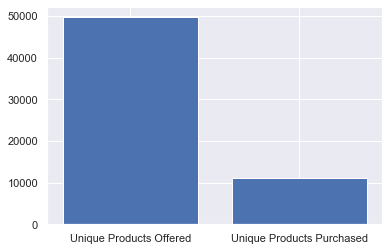

In [68]:
unique_prods_offered = df_prod_dir.product_name.nunique()
unique_prods_purchased = df_all_order_prods.product_name.nunique()

data = ({'Unique Products Offered':df_prod_dir.product_name.nunique(),
         'Unique Products Purchased': df_all_order_prods.product_name.nunique()})
plt.bar(data.keys(), list(data.values()));

#### How many Unique Products / User vs Products / User?


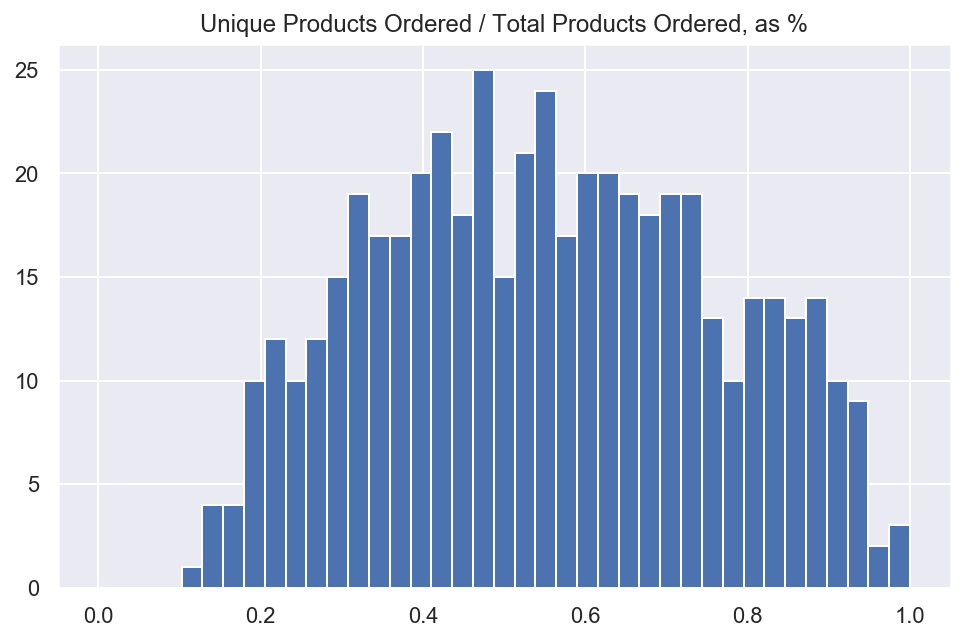

In [141]:
user_prods_nunique = df_all_order_prods.groupby(by='user_id').product_name.nunique()
user_order_prods_counts = df_all_order_prods.groupby(by=['user_id']).count()['product_id']
user_prod_reorder_pct = user_prods_nunique / user_order_prods_counts
data = np.digitize(user_prod_reorder_pct, np.linspace(0, 1, 10))

fig, ax = plt.subplots(figsize=(8,5))

plt.title('Unique Products Ordered / Total Products Ordered, as %')
plt.hist(user_prod_reorder_pct, bins=np.linspace(0, 1, 40));


#### For any given user-product combination, what percentage of future orders include re-orders of that product?

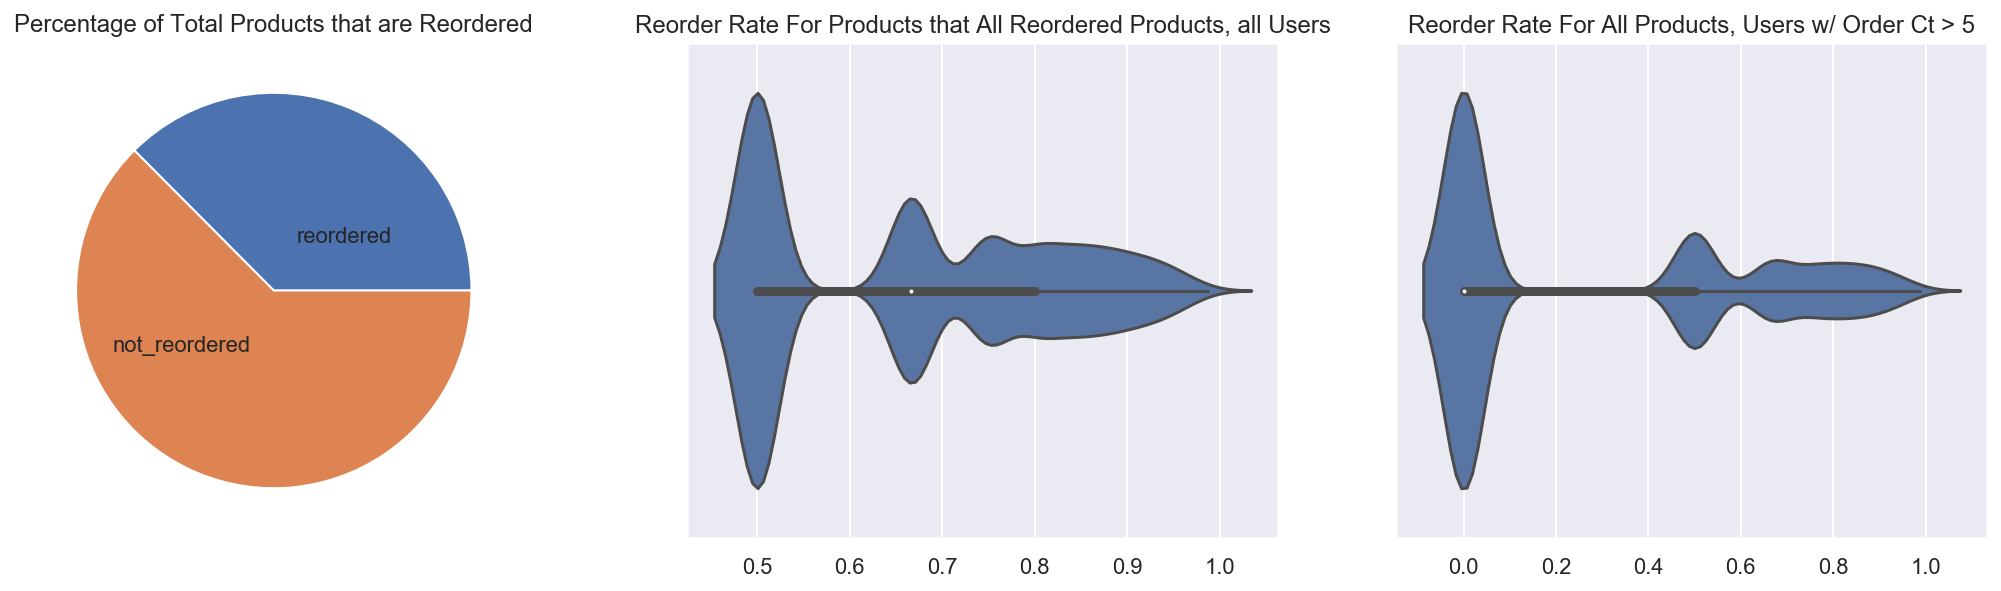

In [311]:
reorder_rates = (df_all_order_prods.groupby(['user_id','product_id'])['reordered'].sum()
                 / df_all_order_prods.groupby(['user_id','product_id'])['order_id'].nunique())

fig, axes = plt.subplots(figsize=(18,10))

ax = plt.subplot(2,3,1)
not_reordered_ct = len(reorder_rates[reorder_rates.values == 0])
plt.pie(x=[not_reordered_ct, len(reorder_rates)], labels=['reordered', 'not_reordered'], labeldistance=0.3)

plt.title("Percentage of Total Products that are Reordered");

ax = plt.subplot(2,3,2)
plt.title("Reorder Rate For Products that All Reordered Products, all Users")

sns.violinplot(reorder_rates[reorder_rates.values > 0]);

ax = plt.subplot(2,3,3)

plt.title("Reorder Rate For All Products, Users w/ Order Ct > 5")
reorder_rates_multi_order_users = (
    df_all_order_prods[df_all_order_prods.user_id.isin(multi_order_users)]
    .groupby(['user_id','product_id']).agg({'reordered':'sum'})['reordered'].values
    / df_all_order_prods[df_all_order_prods.user_id.isin(multi_order_users)]
    .groupby(['user_id','product_id'])['order_id'].nunique().values
)

sns.violinplot(reorder_rates_multi_order_users);

# ax = plt.subplot(2,3,4)

#### Product Popularity

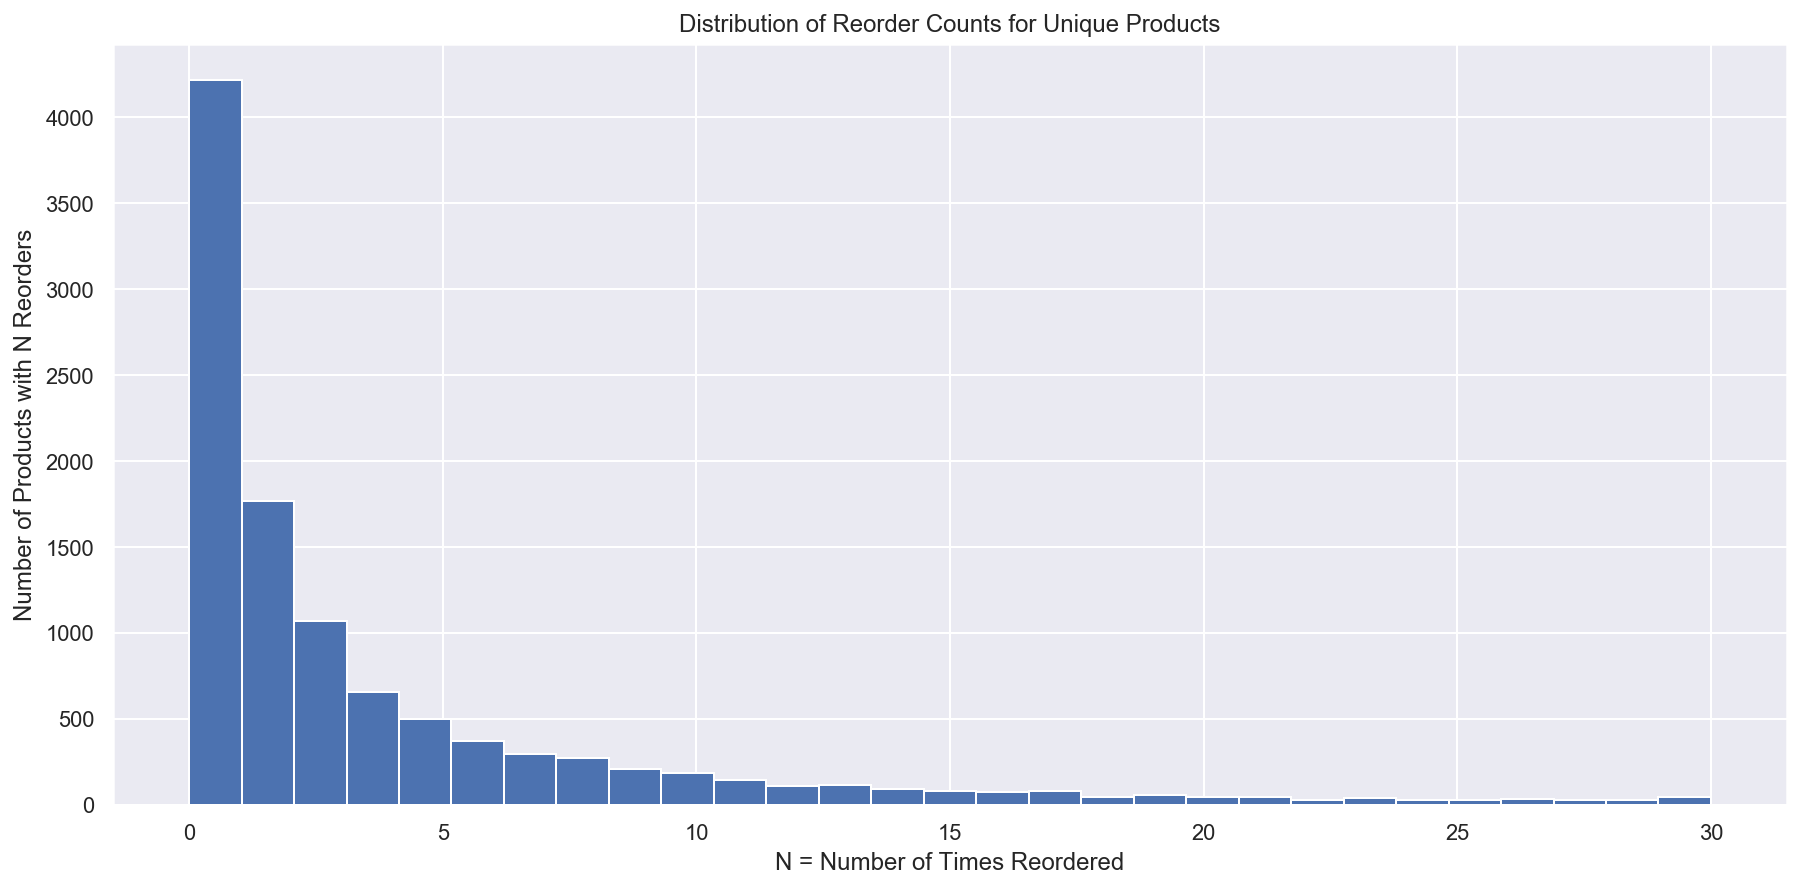

In [328]:
data = {'prod_unique_orders': df_all_order_prods.groupby(by='product_id').agg({'order_id':'nunique'}).values}

fig, ax = plt.subplots(figsize=(15,7))

plt.hist(x='prod_unique_orders',bins=np.linspace(0,30,30), data=data, log=False)

plt.xlabel("N = Number of Times Reordered")
plt.ylabel("Number of Products with N Reorders")

plt.title("Distribution of Reorder Counts for Unique Products");

#### Product Reorders by Department

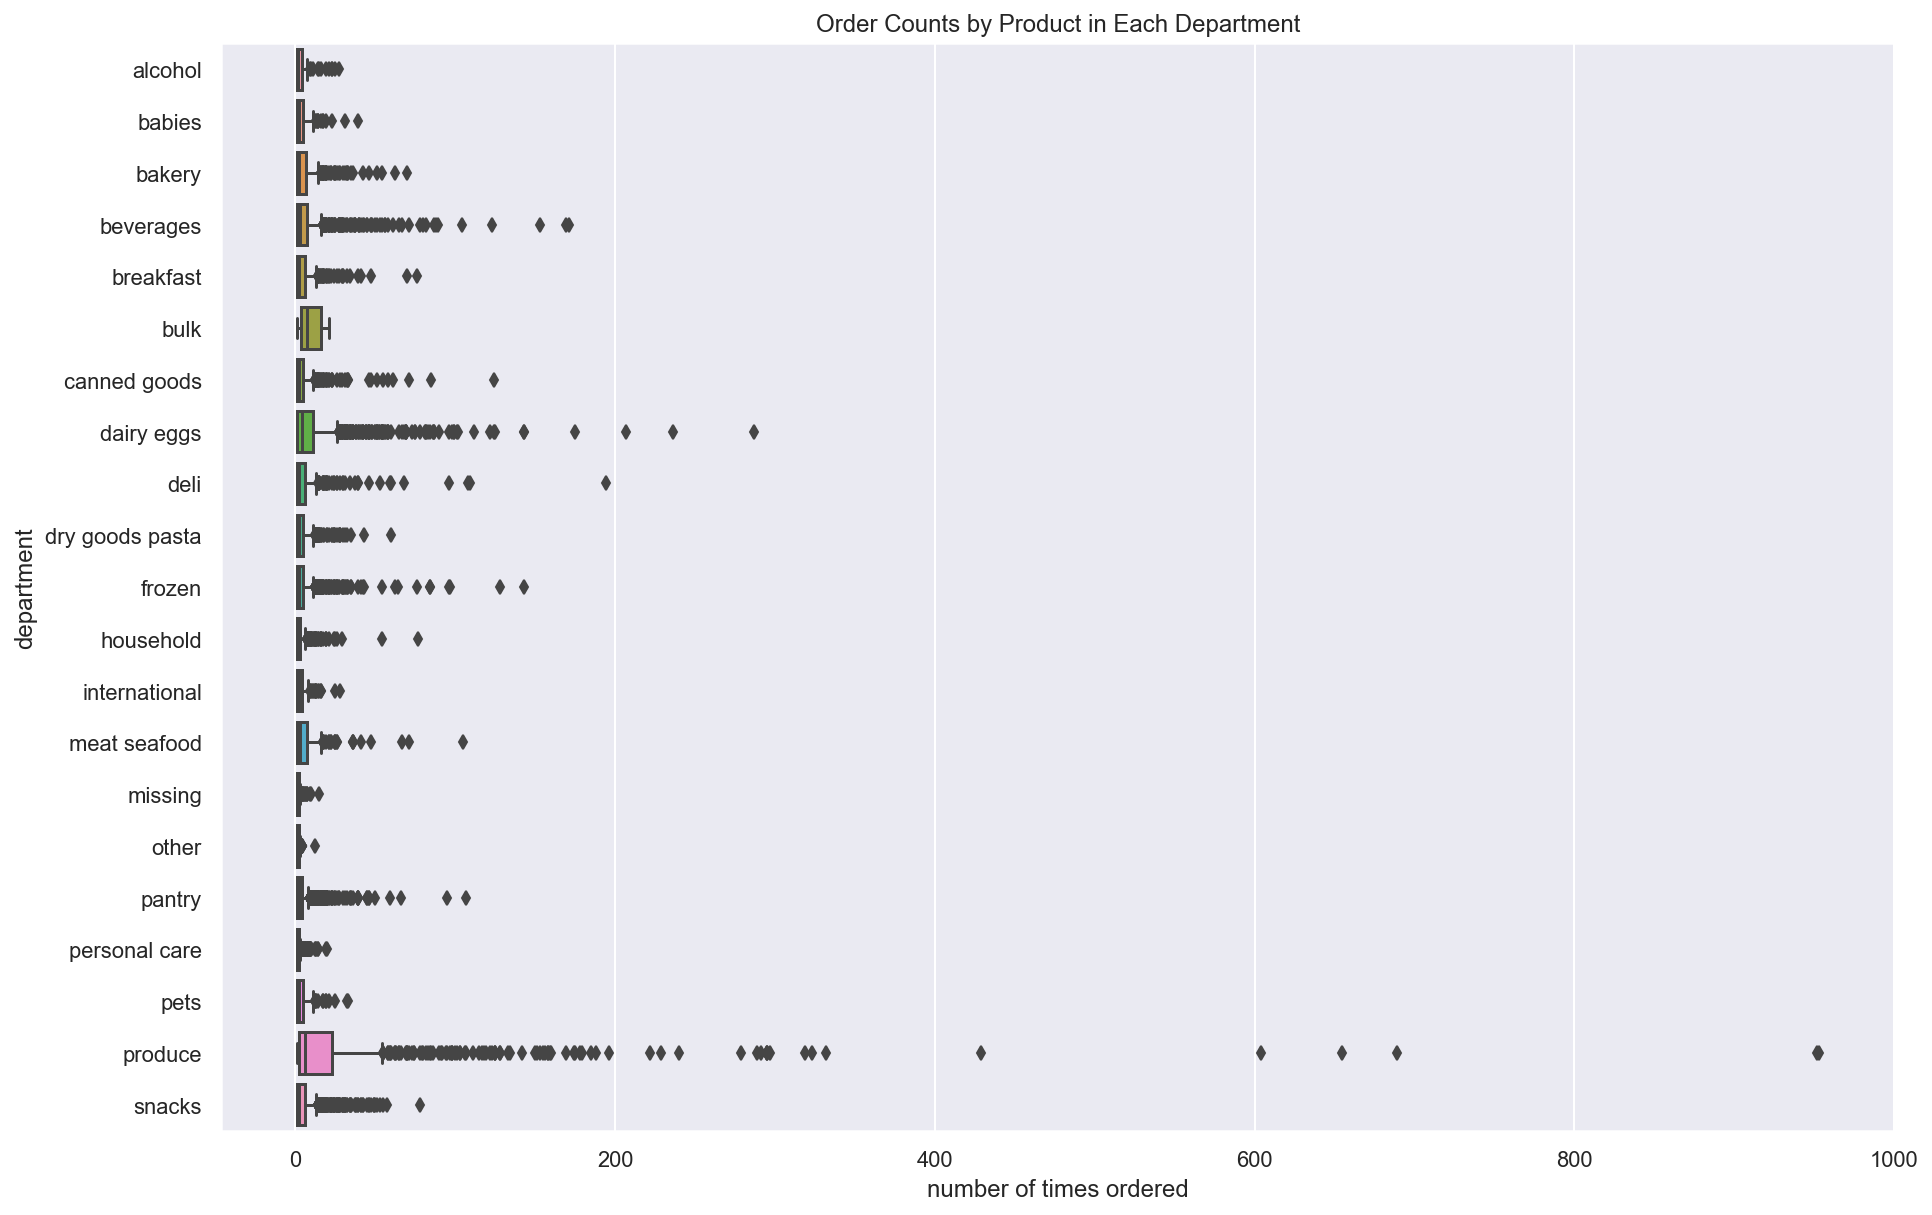

In [15]:
data = df_all_order_prods.groupby(by=['department','product_id']).agg({'order_id':'nunique'}).reset_index()

x_cat = data.department
y_val = data.order_id

fig, ax = plt.subplots(figsize=(15,10))



sns.boxplot(y=x_cat, x=y_val, orient='h', )
plt.title("Order Counts by Product in Each Department")
plt.xlabel('number of times ordered');

In [16]:
for dept in df_dept_index.values:
    
    data.loc[dept]

    prod_orders = data.values
    
    fig, ax = plt.subplots(figsize=(15,10))

    plt.(x=prod_orders, linestyle=)
    plt.title("Order Counts by Product in Each Department")
    plt.xlabel('number of times ordered');

SyntaxError: invalid syntax (<ipython-input-16-2f6071506ca1>, line 9)

## EDA – Orders

In [268]:
df_orders_log.head(3)

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0

## EDA - Order Products

### Prior

In [265]:
print(df_order_prods__prior.shape)
df_order_prods__prior.head(3)

(77425, 4)


order_id  product_id  add_to_cart_order  reordered
333        40       10070                  1          1
334        40       42450                  2          1
335        40       33198                  3          1

In [264]:
# inspect an individual order from prior
df_order_prods__prior[df_order_prods__prior.order_id == 1483].head(3)

order_id  product_id  add_to_cart_order  reordered
14111      1483       32818                  1          1
14112      1483       27582                  2          1
14113      1483       12302                  3          1

### Train

In [387]:
print(df_order_prods__train.shape)
df_order_prods__train.head(1)

(3386, 4)


order_id  product_id  add_to_cart_order  reordered
239       988       45061                  1          0

In [388]:
# inspect an individual order from train
df_order_prods__train[df_order_prods__train.order_id == 988]

order_id  product_id  add_to_cart_order  reordered
239       988       45061                  1          0
240       988       28464                  2          0
241       988       12626                  3          0
242       988        4818                  4          1

# Feature Engineering

## Merge, Append Aisle/Department Columns to Order Log

In [3]:
# Add product name, dept/aisle id to order_prods__prior/train dataframes

df_order_prods_names__prior = pd.merge(
    df_order_prods__prior,
    df_prod_index, on='product_id')

df_order_prods_names__train = pd.merge(
    df_order_prods__train,
    df_prod_index, on='product_id')

# Merge prior orders order-prods dataframe with order log information
df_order_prods_names__prior = pd.merge(df_order_prods_names__prior, df_orders_log, on='order_id')

# Identify User-Product Combinations Suitable as Classifier Targets

We will use a list of the user's previously ordered products as a list of candidate products for the model to classify as "reorder" or "not reorder."

## Create `df_user_prod_candidates` Dataframe
Includes all poss. User-Product Combinations, from `__prior`

In [4]:
#############################################
# Collect actual user reorders from __train #
#############################################

# These user-product candidates will be checked against the actual orders in __train:
# We match candidates against the actually reordered products from the order_prods__train set.

df_user_order_prods_train = pd.merge(
    df_orders_log[['user_id', 'order_id']],
    df_order_prods_names__train[['order_id','product_id','add_to_cart_order']],
    on='order_id',
    how='right'
)
print('actual user carts, shape:\n',df_user_order_prods_train.shape)
print('\nactual user carts, columns:\n', df_user_order_prods_train.columns)

actual user carts, shape:
 (3386, 4)

actual user carts, columns:
 Index(['user_id', 'order_id', 'product_id', 'add_to_cart_order'], dtype='object')


In [5]:
####################################
# Generate user product candidates #
####################################

# We will use a list of previously ordered products as a good candidate set to predict
# the contents of the most recent cart. For each product, we will classify the candidate
# as reorder = 1 or 0.

df_user_prod_cands = df_order_prods_names__prior.groupby('user_id').agg({'product_id':'unique'})

df_user_prod_cands = df_user_prod_cands.product_id.apply(pd.Series).stack().reset_index()
df_user_prod_cands = df_user_prod_cands.drop(labels='level_1', axis=1)
df_user_prod_cands = df_user_prod_cands.rename(columns={0:'product_id'})

# fix float output of prod id
df_user_prod_cands.product_id = df_user_prod_cands.product_id.astype(int)

print("user product candidates for reorder, shape:", df_user_prod_cands.shape)
print('columns:', df_user_prod_cands.columns)

# Merge in "Add to Cart Order" to user-product candidates
df_user_prod_cands = pd.merge(
    df_user_prod_cands,
    df_user_order_prods_train.drop(labels='order_id',axis=1),
    on=['user_id','product_id'],
    how='left'
)
print('\nuser product candidates, with add to cart column, shape:', df_user_prod_cands.shape)
print('columns:,', df_user_prod_cands.columns)

user product candidates for reorder, shape: (32233, 2)
columns: Index(['user_id', 'product_id'], dtype='object')

user product candidates, with add to cart column, shape: (32233, 3)
columns:, Index(['user_id', 'product_id', 'add_to_cart_order'], dtype='object')


In [6]:
################################################
# Create User-Order Index From Training Orders #
################################################

train_user_order_id_index = (
    df_user_order_prods_train
    .groupby('user_id')['order_id']
    .mean() # assuming each user has only one order in __train
)
# all of the order_id values should be ints
# to confirm there's only 1 order per user
train_user_order_id_index

user_id
1      1187899
2      1492625
5      2196797
7       525192
8       880375
        ...   
493    1108486
494    3126335
495    1614375
497     863691
499     188500
Name: order_id, Length: 316, dtype: int64

For the subset of 500 users we are looking at, only 316 users have an order represented in `__train`. All users with orders in `__train` have only 1 order.

In [7]:
############################################################
# Merge User Product candidates with reorders from __train #
############################################################

#this fills out the nan values for order_id
df_user_prod_order_cands = pd.merge(
    df_user_prod_cands,
    train_user_order_id_index,
    left_on='user_id',
    right_index=True,
    how='outer'
)
print('user_prod_order_cands, with order_id from train')
print('user_prod_order cands, columns:',df_user_prod_order_cands.columns)
print(' ')
df_user_prod_order_cands.info()

user_prod_order_cands, with order_id from train
user_prod_order cands, columns: Index(['user_id', 'product_id', 'add_to_cart_order', 'order_id'], dtype='object')
 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32233 entries, 0 to 32232
Data columns (total 4 columns):
user_id              32233 non-null int64
product_id           32233 non-null int64
add_to_cart_order    2099 non-null float64
order_id             20275 non-null float64
dtypes: float64(2), int64(2)
memory usage: 1.2 MB


Rows with null values for order_id mean that the entire user (or an associated order_id) is not represented in the `__train` dataset. We will need to drop them from `df_user_prod_order_cands`.

In [8]:
# First fill empty values in add_to_cart_order with -1
df_user_prod_order_cands.add_to_cart_order = (
    df_user_prod_order_cands.add_to_cart_order
    .apply(lambda x: -1 if pd.isnull(x) else x)
)

df_user_prod_order_cands.dropna(inplace=True)

In [9]:
print('number of null add_to_cart_order\'s in merged candidate dataframe')
print('null order ids mean a product was not reordered')
print('nulls:', df_user_prod_order_cands[df_user_prod_order_cands.add_to_cart_order == -1].shape[0])
print('total:', df_user_prod_order_cands.shape[0])

number of null add_to_cart_order's in merged candidate dataframe
null order ids mean a product was not reordered
nulls: 18176
total: 20275


In [10]:
# Create a new column categorizing each user-prod-order combination
# as reordered 0/1. Based on sign of value in add_to_cart_order.

df_user_prod_order_cands['reordered'] = (df_user_prod_order_cands.add_to_cart_order
                                         .apply(lambda x: 1 if x>0 else 0))
df_user_prod_order_cands.sample(3)

user_id  product_id  add_to_cart_order   order_id  reordered
22592      346       35217               -1.0   980530.0          0
8894       150       15137               -1.0  1575396.0          0
16256      255       29270               -1.0  2008056.0          0

In [12]:
print('percent of possible products that were reordered:')
print(df_user_prod_order_cands.reordered.sum() / df_user_prod_order_cands.shape[0])

percent of possible products that were reordered:
0.10352651048088779


In [13]:
##########################################
# Create new ML-ready Dataframe as df_Xy #
##########################################

# Now, we finally have a dataframe we can feed into a model.
# Our target is 'reordered' and our features are any other columns
# in this user-product-order dataframe.

df_Xy = df_user_prod_order_cands
df_Xy = df_Xy.rename(columns = {'order_id':'order_id_ref'})
df_Xy.sample(3)

user_id  product_id  add_to_cart_order  order_id_ref  reordered
15778      243       46667               -1.0     2698993.0          0
5028        86        5876                3.0      613340.0          1
32061      497       29447               -1.0      863691.0          0

# User Profiles

## Initialize User Dataframe

In [14]:
# Create a users database with some historical information for each user
df_user_profs = pd.DataFrame()
df_user_profs['user_id'] = user_subset

def get_user_orders(user_id, df_orders_log):
    '''
    
    Return an ordered list of tuples,
    e.g. [(1, order_id_1), ... , (latest_order_number, latest_order_id)]
    
    '''
    
    user_orders = df_orders_log[df_orders_log.user_id == user_id]
    
    return (user_orders[['order_number', 'order_id']]).to_numpy() 

In [15]:
df_user_profs['order_id_history'] = df_user_profs.user_id.apply(
    get_user_orders, df_orders_log=df_orders_log
)
df_user_profs['num_orders'] = df_user_profs.order_id_history.apply(lambda x: len(x))
df_user_profs.head(2)

user_id                                   order_id_history  num_orders
0        1  [[1, 2539329], [2, 2398795], [3, 473747], [4, ...          11
1        2  [[1, 2168274], [2, 1501582], [3, 1901567], [4,...          15

### Order Sizes (User)

In [16]:
#############################################
# Merge average user order sizes into df_Xy #
#############################################

user_order_sizes = (df_order_prods_names__prior.groupby(['user_id', 'order_id'])['product_id']
                  .nunique().reset_index()
                  .rename(columns={'product_id':'order_size'})
                 )
# user_order_sizes.head(3)

df_Xy = pd.merge(df_Xy,
                 user_order_sizes.groupby('user_id').order_size.mean().reset_index(),
                 on='user_id',
                 how='left'
                ).rename(columns={'order_size':'avg_order_size'})
df_Xy

user_id  product_id  add_to_cart_order  order_id_ref  reordered  \
0            1       13176               -1.0     1187899.0          0   
1            1       41787               -1.0     1187899.0          0   
2            1         196                1.0     1187899.0          1   
3            1       12427               -1.0     1187899.0          0   
4            1       25133                2.0     1187899.0          1   
...        ...         ...                ...           ...        ...   
20270      499        5077               -1.0      188500.0          0   
20271      499       26165               -1.0      188500.0          0   
20272      499        7515               -1.0      188500.0          0   
20273      499       34276               -1.0      188500.0          0   
20274      499       21386               -1.0      188500.0          0   

       avg_order_size  
0            5.900000  
1            5.900000  
2            5.900000  
3            5.900000  
4            5.900000  
...               ...  
20270        9.833333  
20271        9.833333  
20272        9.833333  
20273        9.833333  
20274        9.833333  

[20275 rows x 6 columns]

In [17]:
## Average Order Sizes by User ##

def avg_user_order_sizes(order_id_history, df_order_prods):
    
    order_id_list = order_id_history[:,1]

    avg_order_size = (
        df_order_prods[df_order_prods.order_id.isin(order_id_list)]              
        .groupby('order_id')
        .agg('nunique')
    ).mean()['product_id']

    return avg_order_size


df_user_profs['avg_order_size'] = (df_user_profs.order_id_history
                                    .apply(avg_user_order_sizes, df_order_prods=df_order_prods__prior)
                                   )

df_user_profs.sample(2)

user_id                                   order_id_history  num_orders  \
424      425  [[1, 2257836], [2, 3216542], [3, 2217301], [4,...           8   
99       100  [[1, 680467], [2, 3159209], [3, 2443738], [4, ...           6   

     avg_order_size  
424       14.142857  
99         5.400000

In [18]:
# # Create a dictionary of unique orders for the same product, by user.
# def get_user_product_counts(user_id, df_order_prods__prior, df_prod_dir):
    
#     '''
    
#     Return an ordered list of tuples,
#     e.g. [(1, order_id_1), ... , (latest_order_number, latest_order_id)]
    
#     '''
    
#     user_prods = (df_order_prods__prior
#                   .groupby(by=['user_id','product_id'])['order_id']
#                   .nunique().loc[user_id]
#                  )
    
#     user_prods = (
#         pd.merge(user_prods,
#                  df_prod_index.drop(labels='product_name', axis=1),
#                  on='product_id').rename(columns={'order_id':'order_ct'})
#     ).set_index('product_id').to_dict(orient='index')
    
#     return user_prods

# df_user_profs['product_counts'] = df_user_profs.user_id.apply(
#     get_user_product_counts, df_order_prods__prior = df_order_prods__prior, df_prod_dir = df_prod_dir
# );

# print('sample row of user-prod order counts')
# df_user_profs.product_counts.sample(1);

In [19]:
df_user_profs.sample(1)

user_id                                   order_id_history  num_orders  \
452      453  [[1, 2516692], [2, 804464], [3, 602691], [4, 1...          14   

     avg_order_size  
452        7.461538

### Merge user-count(product) information into `df_prod_candidates` dataframe.

In [20]:
###########################################
# Merge prev-user-order counts into df_Xy #
###########################################

user_prod_order_cts = (df_order_prods_names__prior.groupby(['user_id', 'product_id'])['order_id']
                  .nunique().reset_index()
                  .rename(columns={'order_id':'prev_order_ct'})
                 )

df_Xy = pd.merge(df_Xy, user_prod_order_cts, on=['user_id','product_id'], how='left') # .sort_values(['user_id','product_id'])
df_Xy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20275 entries, 0 to 20274
Data columns (total 7 columns):
user_id              20275 non-null int64
product_id           20275 non-null int64
add_to_cart_order    20275 non-null float64
order_id_ref         20275 non-null float64
reordered            20275 non-null int64
avg_order_size       20275 non-null float64
prev_order_ct        20275 non-null int64
dtypes: float64(3), int64(4)
memory usage: 1.2 MB


Previous Order Counts that are null mean the product was ordered for the first time. We can fill that value with 0.

### Departmental Unique Check-ins Dictionary (User)

In [21]:
###############################################
# Add product/dept/aisle information to df_Xy #
###############################################

df_Xy = pd.merge(df_Xy, df_prod_index.drop(labels='product_name',axis=1), on='product_id', how='left')
df_Xy.head(1)

user_id  product_id  add_to_cart_order  order_id_ref  reordered  \
0        1       13176               -1.0     1187899.0          0   

   avg_order_size  prev_order_ct  aisle_id  department_id  
0             5.9              2        24              4

In [22]:
####################################
# User-Department Visits --> df_Xy #
####################################

user_dept_visits = (df_order_prods_names__prior.groupby(['user_id', 'department_id'])['order_id']
                  .nunique().reset_index()
                  .rename(columns={'order_id':'dept_visits'})
                 )

df_Xy = pd.merge(df_Xy, user_dept_visits, on=['user_id','department_id'])
df_Xy.head(1)

user_id  product_id  add_to_cart_order  order_id_ref  reordered  \
0        1       13176               -1.0     1187899.0          0   

   avg_order_size  prev_order_ct  aisle_id  department_id  dept_visits  
0             5.9              2        24              4            2

## Aisle Check-ins

In [23]:
###############################
# User-Aisle Visits --> df_Xy #
###############################

user_aisle_visits = (df_order_prods_names__prior.groupby(['user_id', 'aisle_id'])['order_id']
                  .nunique().reset_index()
                  .rename(columns={'order_id':'aisle_visits'})
                 )

df_Xy = pd.merge(df_Xy, user_aisle_visits, on=['user_id','aisle_id'])
df_Xy.head(1)

user_id  product_id  add_to_cart_order  order_id_ref  reordered  \
0        1       13176               -1.0     1187899.0          0   

   avg_order_size  prev_order_ct  aisle_id  department_id  dept_visits  \
0             5.9              2        24              4            2   

   aisle_visits  
0             2

In [24]:
# Create a dictionary with department IDs as keys
# each value is the number of unique department check-ins.
# i.e. An order with two products from the same department
# should count as 1 unique check-in.

user_hist = pd.DataFrame()
user_hist['dept_dict'] = dict(zip(df_dept_index.department_id.values,0*df_dept_index.department_id.values))

In [25]:
# def unique_dept_checkins(user_id, orders, order_prods, subset='prior'):
    
#     user_orders = orders[(orders.user_id == user_id) & (orders.eval_set == subset)]
    
#     gb_order = user_orders.groupby('order_id')
    
    
    
#     for group in gb_order:
        
        
    
    
#     return order_sizes


# user_hist['prior_order_sizes'] = pd.Series(user_hist.index.values).apply(
#     order_sizes,
#     orders=orders,
#     order_prods=all_order_prods
# )

# Department Profiles

In [26]:
# Create a department profile dataframe

df_dept_profs = pd.DataFrame()
df_dept_profs['department_id'] = df_dept_index.department_id
df_dept_profs.head(2)

department_id
0              1
1              2

### Orders / Department

In [27]:
# Calculate number of orders in each department.
dept_nunique = df_order_prods__prior.groupby('department_id').nunique()['order_id'].reset_index()
dept_nunique.rename(columns={'order_id':'num_orders'}, inplace=True)

df_dept_profs = pd.merge(df_dept_profs, dept_nunique, on='department_id')
df_dept_profs.head(3)
# df_user_profs.set_index('user_id', inplace=True)

KeyError: 'department_id'

# Aisle Profiles

# User-Product Profiles

## Average Time of Day for user-product combinations

In [28]:
###############################################
# User-product time of day averages --> df_Xy #
###############################################

_ = (df_order_prods_names__prior
     .groupby(by=['user_id', 'product_id'])
     .agg({'order_hour_of_day':['mean','var']})
     .reset_index().fillna(99)
    )

_.columns = ['user_id', 'product_id', 'prod_hod_mean', 'prod_hod_var' ]

df_Xy = pd.merge(df_Xy, _, on = ['user_id','product_id'])
df_Xy.sample(2)

user_id  product_id  add_to_cart_order  order_id_ref  reordered  \
12475      314       39002               -1.0      877974.0          0   
18508      466       47547               -1.0     3293782.0          0   

       avg_order_size  prev_order_ct  aisle_id  department_id  dept_visits  \
12475        2.200000              1        98              7            1   
18508       22.129032              1       104             13           20   

       aisle_visits  prod_hod_mean  prod_hod_var  
12475             1           12.0          99.0  
18508             5           18.0          99.0

## Get Latest Order TOD / Weekday for latest user

To get meaningful interactions we will also want the actual tod the cart is opened for __train

In [29]:
df_Xy = pd.merge(df_Xy, df_orders_log.drop(labels = ['user_id', 'eval_set'], axis=1),
         left_on = 'order_id_ref', right_on='order_id', how='left'
        ).drop(labels = ['order_id'], axis=1)
df_Xy.head(2)

user_id  product_id  add_to_cart_order  order_id_ref  reordered  \
0        1       13176               -1.0     1187899.0          0   
1        1       41787               -1.0     1187899.0          0   

   avg_order_size  prev_order_ct  aisle_id  department_id  dept_visits  \
0             5.9              2        24              4            2   
1             5.9              1        24              4            2   

   aisle_visits  prod_hod_mean  prod_hod_var  order_number  order_dow  \
0             2           11.0          32.0            11          4   
1             2           15.0          99.0            11          4   

   order_hour_of_day  days_since_prior_order  
0                  8                    14.0  
1                  8                    14.0

In [30]:
# interaction columns between prod_hod_mean and order_hour_of_day
# add an additional column that divides this column by the prod_hod_var

# df_Xy['prod_hod_var'] = df_Xy['prod_hod_var'].apply(lambda x: -99 if x==0 else x).sample(40).fillna(-99)
df_Xy['prod_hod_delta'] = df_Xy['prod_hod_mean'] - df_Xy['order_hour_of_day']
df_Xy['prod_hod_delta_w'] = (df_Xy['prod_hod_delta'] / df_Xy['prod_hod_var']).fillna(-99).apply(lambda x: -99 if abs(x) > 24 else x)

# Feature Pairplots

In [152]:
df_Xy.columns

Index(['user_id', 'product_id', 'add_to_cart_order', 'order_id_ref',
       'reordered', 'avg_order_size', 'prev_order_ct', 'aisle_id',
       'department_id', 'dept_visits', 'aisle_visits', 'prod_hod_mean',
       'prod_hod_var', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'prod_hod_delta', 'prod_hod_delta_w'],
      dtype='object')

//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


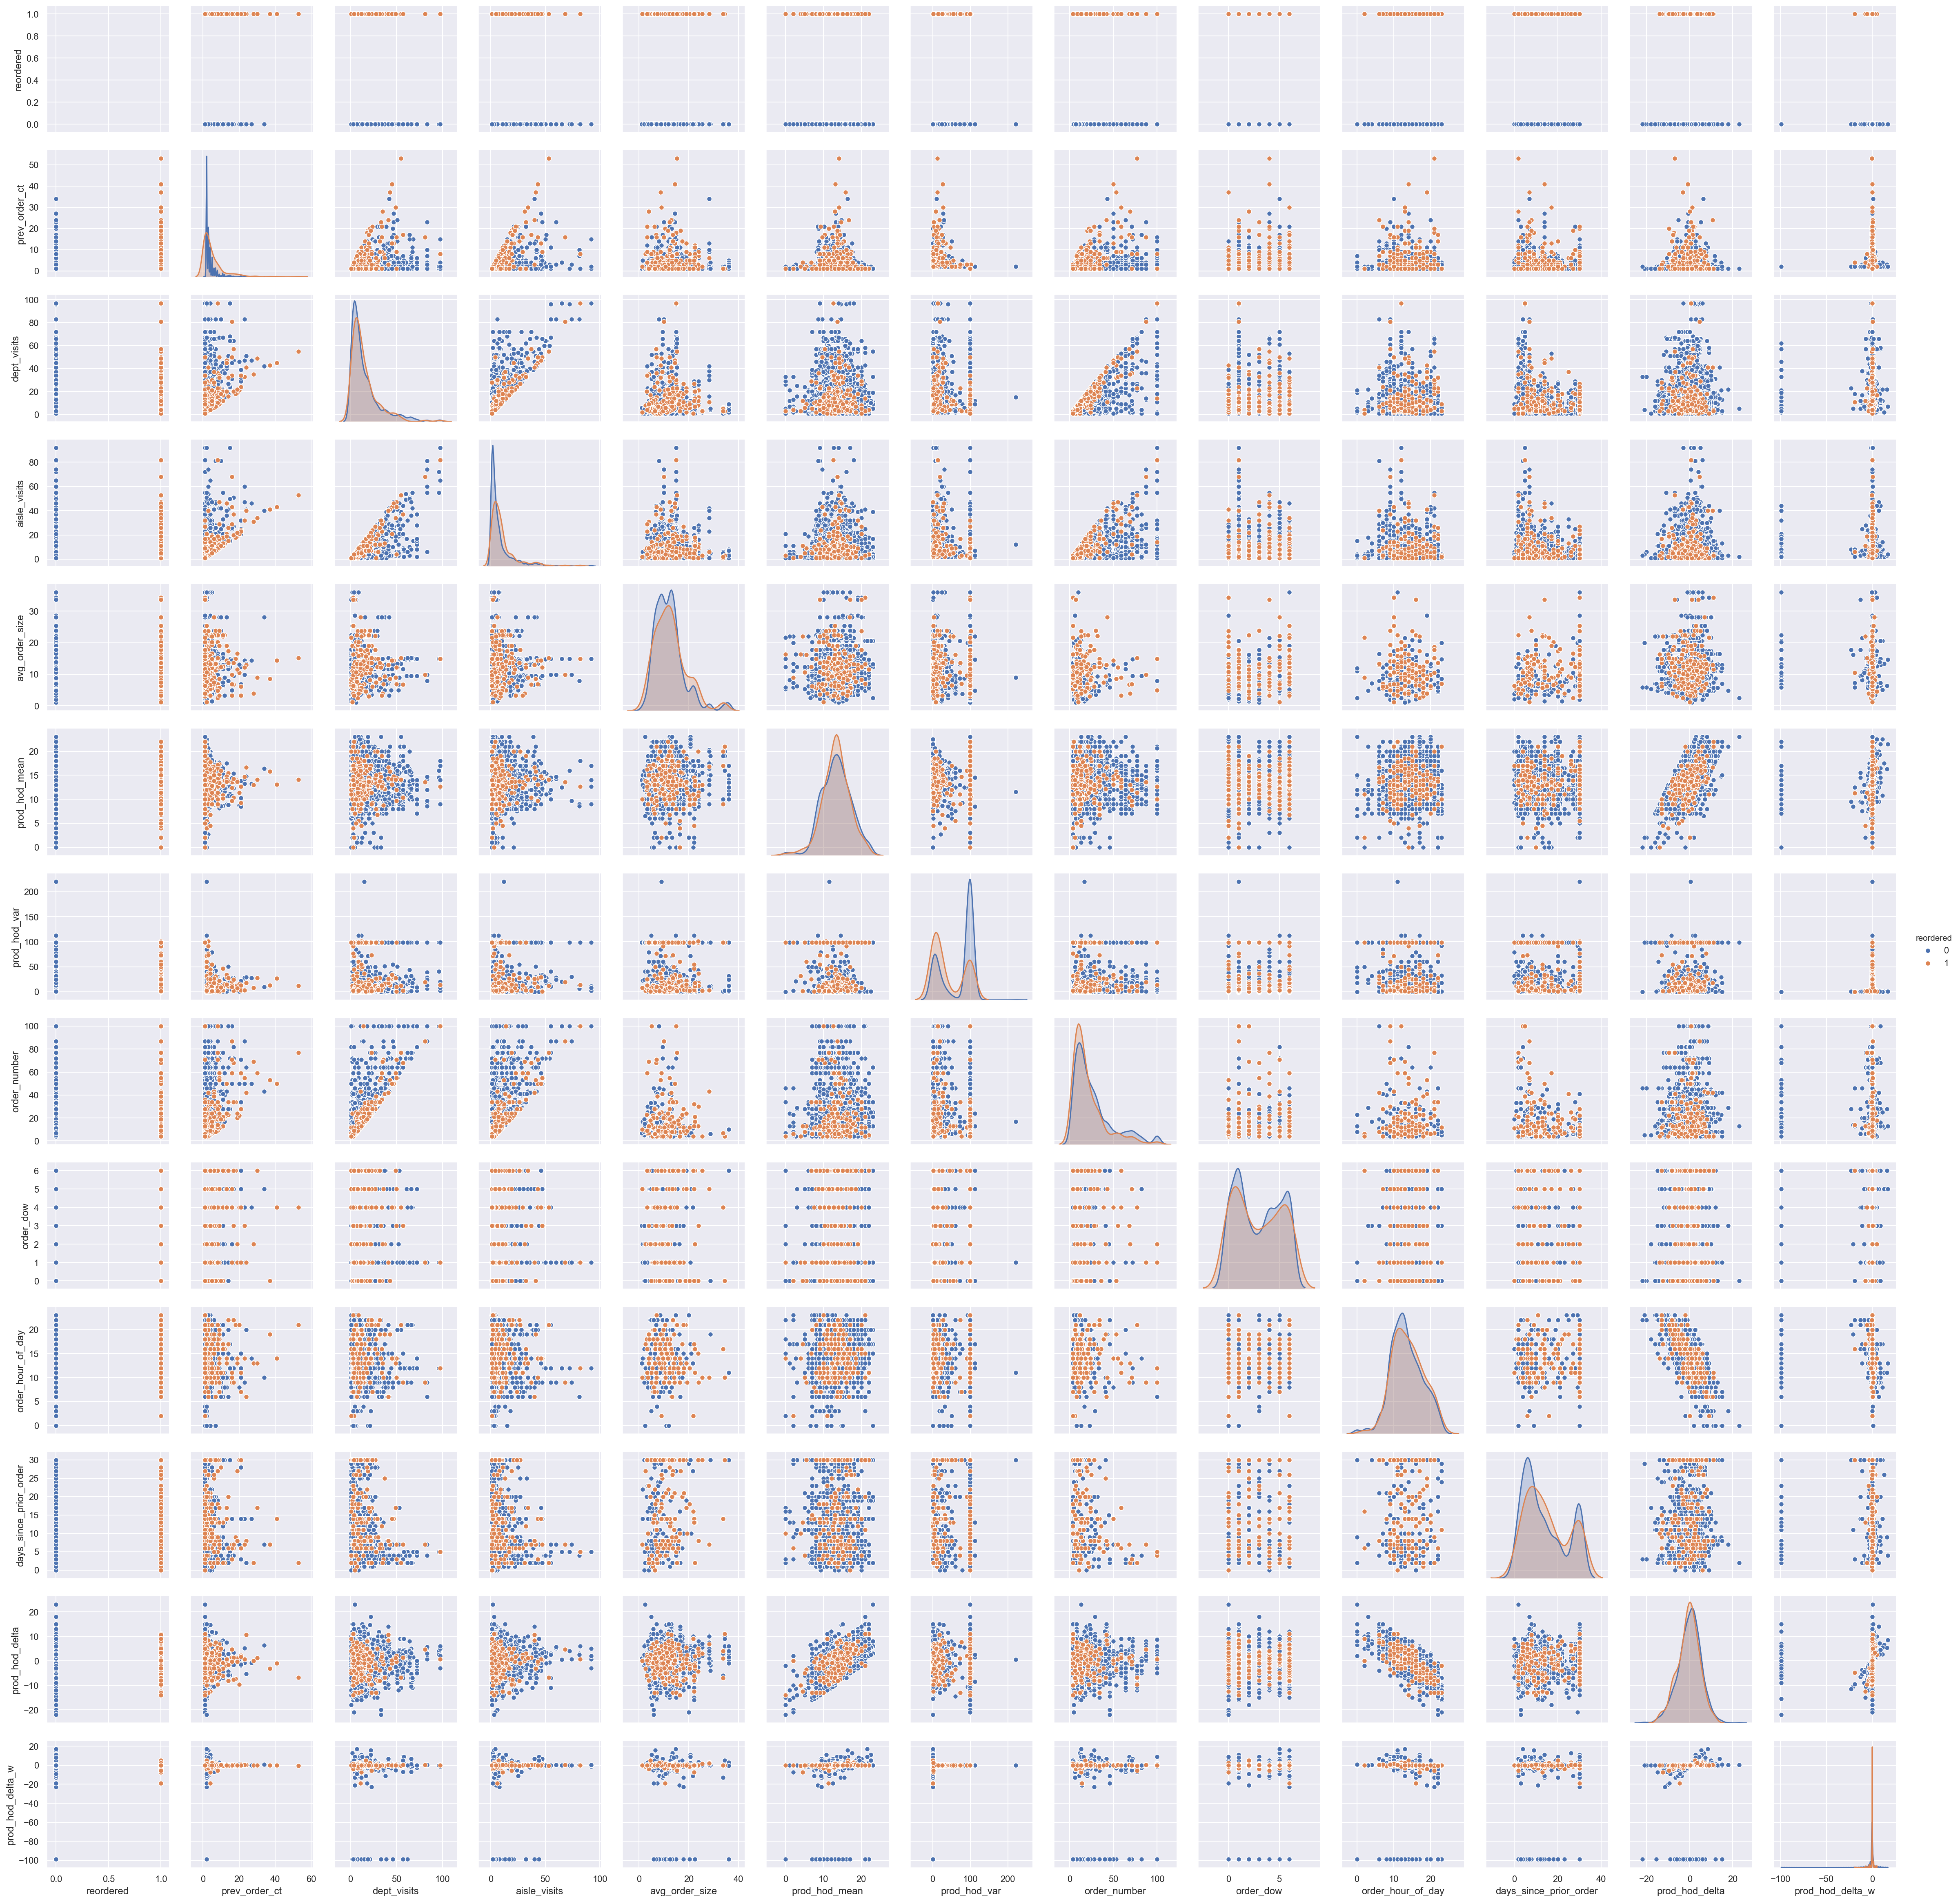

In [97]:
features_and_target = ['reordered', 'prev_order_ct', 'dept_visits',
       'aisle_visits', 'avg_order_size', 'prod_hod_mean', 'prod_hod_var',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'prod_hod_delta', 'prod_hod_delta_w']

sns.pairplot(hue='reordered', data = df_Xy.sample(2000), x_vars=features_and_target, y_vars=features_and_target)

# Modeling & Tests

Model Runs and logs.

In [186]:
df_Xy.shape

(20275, 19)

In [256]:
#################################

### Modeling Helper Functions ###

#################################

def train_val_test_split(df, features, target, train_and_val=True, oversample=True):
    '''
    
    default:
    returns X_train, X_val, y_train, y_val
    
    if train_and_val==False:
    returns X_train, X_val, X_test, y_train, y_val, y_test
    
    '''
    
    X = df[features]
    y = df[target]
    
    if oversample:
        ros = over_sampling.RandomOverSampler(sampling_strategy="minority", random_state=4444)
        X, y = ros.fit_resample(X, y)
        X = pd.DataFrame(X)
        X.columns = features
    
    X, X_test, y, y_ = train_test_split(X, y, test_size=0.2, random_state=4444)
    X_train, X_val, y_train, y_val = train_test_split(X, y)
    
    if train_and_val:
        return X_train, X_val, y_train, y_val
    else:
        return X_train, X_val, X_test, y_train, y_val, y_test
    
class BaselineModel(object):
    
    def __init__(self):
        return None
    
    def fit(self, X_train, y_train):
#         self.C = pd.DataFrame(y_train).mode()
        self.C = 1
    
    def predict(self, X_val):
        return np.full(X_val.shape[0], self.C)
    
def UserCartPredictionRelevance(df, preb_prob):  
    '''
    
    Custom function to quantify the relevance of
    cart predictions. Requires a re-merging of the
    (soft?) prediction probabilities for the positive class.
    
    Scale from -100 to 100, where 100 indicates the cart was predicted perfectly,
    with no irrelevant products offered. -100 means the prediction list was empty
    or there were no matches between the predictions and actual user cart.
    
    '''
    
    user_cart_priority = df[['user_id','add_to_cart_order']]
    user_cart_priority = add_to_cart_order.apply(lambda x: 0 if x < 0 else x)
    
    
    
def CheckModelPerformance(estimators, X_train, X_val, y_train, y_val, print_baseline=False, thresh=0.5):
    
    y_val = np.ravel(y_val)
    y_train = np.ravel(y_train)
    
    print(f"Testing {len(estimators)} Models Against Gaussian NB")
    print(f".............................................")
    print('')
    
    if print_baseline == True:
        estimators = [['BASELINE', GaussianNB()]] + estimators
        
    def plot_auc_roc_curve(fpr, tpr, title):
        plt.plot(fpr, tpr, color='orange', label='ROC')
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title + ' ROC Curve')
        plt.legend()
#         plt.show()
        
    plot_count = len(estimators)
    
#     plt.figure(figsize=(15,plot_count*3))
    fig, axes = plt.subplots(plot_count//2 + 1, 2, sharex='all', sharey='all')
    
    for i, est in enumerate(estimators):
        
        name = est[0]
        est = est[1]
        print("__________", name, "__________")
        est.fit(X_train, y_train)
        
        # Score on Training Set
        pred_train = (est.predict_proba(X_train)[:,1] >= thresh).astype(bool)
        acc = accuracy_score(y_train, pred_train)
        f1 = f1_score(y_train, pred_train)
        roc = roc_auc_score(y_train, pred_train)
        prec = precision_score(y_train, pred_train)
        print(f'Train Set precision={prec} and f1={f1}')
        
        ### Recommendation Score
        n_recs=10
        def topNpredictionScore(group, n_recs=10): 
            
#             n_reordered = group['reordered'].sum()

            _ = group.sort_values('pred_proba', ascending=False)
            _ = _[:min(n_recs, _.shape[0])]
            
            guessed_correct = sum(_['reordered'])

#             n = min(n_reordered, n_recs)
            return guessed_correct / 10

        topNscores_train = (pd.concat([pd.Series(est.predict_proba(X_train)[:,1],name='pred_proba'),
                   X_train['user_id'], pd.Series(y_train, name='reordered')], axis=1).groupby('user_id').apply(topNpredictionScore)
        )

        print(f'Training top {n_recs} Score, mean={topNscores_train.mean()}, std={topNscores_train.std()}')
        
        # Score on Training Set
        pred_val = (est.predict_proba(X_val)[:,1] >= thresh).astype(bool)
        acc = accuracy_score(y_val, pred_val)
        f1 = f1_score(y_val, pred_val)
        roc = roc_auc_score(y_val, pred_val)
        prec = precision_score(y_val, pred_val)
        print(f'Validation Set precision={prec} and f1={f1}')
        
        topNscores_val = (pd.concat([pd.Series(est.predict_proba(X_val)[:,1],name='pred_proba'),
                   X_val['user_id'], pd.Series(y_val, name='reordered')], axis=1).groupby('user_id').apply(topNpredictionScore)
        )

        print(f'Validation top {n_recs} Score, mean={topNscores_val.mean()}, std={topNscores_val.std()}')
        
        print('-------')
        print('')
                
        fig, ax=plt.subplots(num=i, clear=True)
        title = name
        fpr, tpr, _ = roc_curve(y_val, pred_val, drop_intermediate=False)
        plot_auc_roc_curve(fpr,tpr, title)
    
    return None

#### Models using minimal features:

In [55]:
########################################
##          MODEL RUN TEMPLATE        ##
########################################

df = df_Xy
target = 'reordered'
features = ['user_id', 'product_id', 'aisle_id', 'department_id']

X_train, X_val, y_train, y_val = train_val_test_split(df, features, target, train_and_val=True)

estimators = [
    ['RF with 100 est, depth 2', RandomForestClassifier(n_estimators=100, max_depth=2)],
    ['RF with 200 est, depth 2', RandomForestClassifier(n_estimators=200, max_depth=2)]
    ]

CheckModelPerformance(estimators, X_train, X_val, y_train, y_val, print_baseline=True)

Testing 2 Models Against Baseline
features:
['user_id', 'product_id', 'aisle_id', 'department_id']
.............................................

__________ BASELINE __________
Train Set precision=0.06473964527638451 and f1=0.12160652712350058
Validation Set precision=0.06390569257018769 and f1=0.12013413033969966
-------

__________ RF with 100 est, depth 2 __________
Train Set precision=0.8 and f1=0.006364359586316626
Validation Set precision=0.0 and f1=0.0
-------

__________ RF with 200 est, depth 2 __________


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Train Set precision=0.0 and f1=0.0
Validation Set precision=0.0 and f1=0.0
-------



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Models using User Order Counts per Product / Dept / Aisle

In [50]:
########################################
##          MODEL RUN TEMPLATE        ##
########################################

df = df_Xy
target = 'reordered'
features = ['user_id',
            'product_id',
#             'reordered_in_order_id',
            'aisle_id', 'department_id',
            'prev_order_ct', 'dept_visits', 'aisle_visits', 'avg_order_size']

X_train, X_val, y_train, y_val = train_val_test_split(df, features, target, train_and_val=True)

estimators = [
#     ['RF with 2000 est, depth 2', RandomForestClassifier(n_estimators=2000, max_depth=2)],
    ['RF with 2000 est, depth 3', RandomForestClassifier(n_estimators=2000, max_depth=3)],
    ['XGB with Defaults', xgb.XGBClassifier(n_estimators=3000, verbosity=1)]
    ]

CheckModelPerformance(estimators, X_train, X_val, y_train, y_val, print_baseline=True)

Testing 2 Models Against Gaussian NB
.............................................

__________ BASELINE __________
Train Set precision=0.7634939553890686 and f1=0.3739939113390883
Validation Set precision=0.7660878447395302 and f1=0.3800836183960471
-------

__________ RF with 2000 est, depth 3 __________


KeyboardInterrupt: 

#### Models using Basic User / Time of Day Features

In [33]:
########################################
##          MODEL RUN TEMPLATE        ##
########################################

df = df_Xy
target = 'reordered'
features = ['user_id', 'product_id', 'aisle_id', 'department_id', 'prev_order_ct', 'dept_visits',
       'aisle_visits', 'avg_order_size', 'prod_hod_mean', 'prod_hod_var',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'prod_hod_delta', 'prod_hod_delta_w']

X_train, X_val, y_train, y_val = train_val_test_split(df, features, target, oversample=True)



n = 1000
depth = 5

estimators = [
    [f'RF with {n} est, depth {depth}', RandomForestClassifier(n_estimators=n, max_depth=depth)],
#     [f'XGB with {n} est, depth 2, lr = 0.2', xgb.XGBClassifier(n_estimators=n, max_depth=2, learning_rate=0.2, verbosity=1)],
#     [f'XGB with {n} est, depth 2, lr = 0.3', xgb.XGBClassifier(n_estimators=n, max_depth=2, learning_rate=0.3, verbosity=1)],
#     [f'XGB with {n} est, depth 3, lr = 0.2', xgb.XGBClassifier(n_estimators=n, max_depth=3, learning_rate=0.2, verbosity=1)],
    [f'XGB with {n} est, depth 4, lr = 0.2', xgb.XGBClassifier(n_estimators=n, max_depth=4, learning_rate=0.2, verbosity=1)],
#     [f'XGB with {n} est, depth 8, lr = 0.1', xgb.XGBClassifier(n_estimators=n, max_depth=8, learning_rate=0.1, verbosity=1)]
    ]

CheckModelPerformance(estimators, X_train, X_val, y_train, y_val, print_baseline=True, thresh=0.25)

Testing 2 Models Against Gaussian NB
.............................................

__________ BASELINE __________
Train Set precision=0.6585710721117858 and f1=0.6907441332984384
Validation Set precision=0.6541223075018568 and f1=0.6865012342471093
-------

__________ RF with 1000 est, depth 5 __________
Train Set precision=0.5588528286058827 and f1=0.7111689351481185
Validation Set precision=0.5547570692079362 and f1=0.7060343970573615
-------

__________ XGB with 1000 est, depth 4, lr = 0.2 __________
Train Set precision=0.8908243375858685 and f1=0.9418529246465781
Validation Set precision=0.797723292469352 and f1=0.8859713104789692
-------



### ROC AUC Test

Testing 6 Models Against Gaussian NB
.............................................

__________ RF with 500 est, depth 5 __________
Train Set precision=0.555578598092078 and f1=0.708800476237722
Training top 10 Score, mean=0.7845890410958914, std=0.18556730779265548
Validation Set precision=0.5453421906380349 and f1=0.7000495785820526
Validation top 10 Score, mean=0.6318840579710143, std=0.2367008248346599
-------

__________ XGB with 500 est, depth 2, lr = 0.2 __________
Train Set precision=0.6463660218465858 and f1=0.7749487854843431
Training top 10 Score, mean=0.8410958904109601, std=0.1859945802989405
Validation Set precision=0.6349206349206349 and f1=0.7654239524909271
Validation top 10 Score, mean=0.6521739130434783, std=0.24350908646663655
-------

__________ XGB with 500 est, depth 2, lr = 0.3 __________
Train Set precision=0.6654593143071255 and f1=0.7904458126251761
Training top 10 Score, mean=0.851027397260275, std=0.18583601185398244
Validation Set precision=0.65087653860499

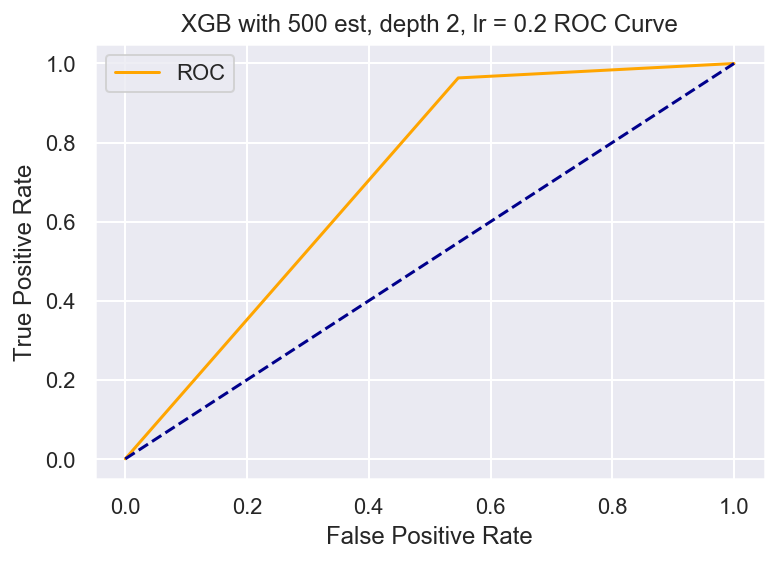

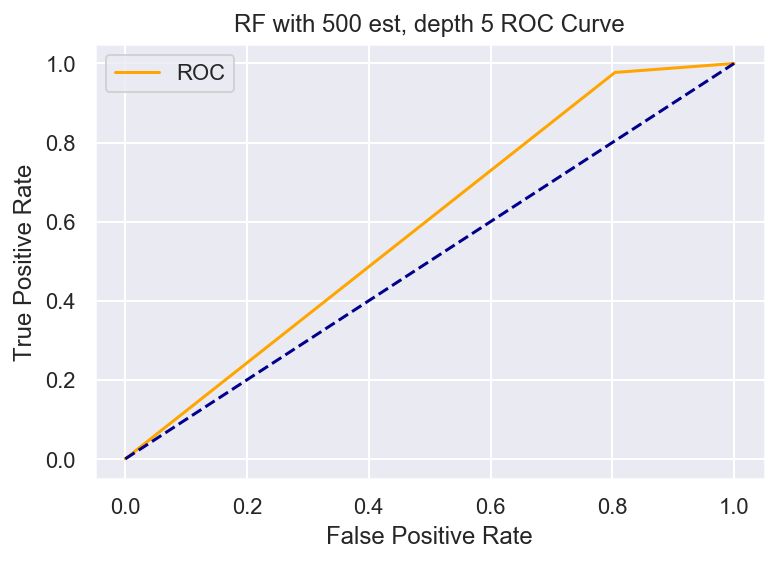

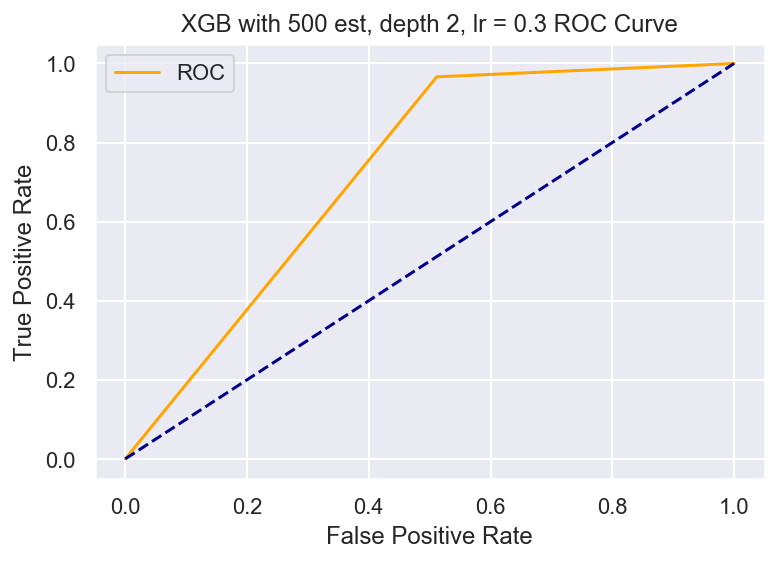

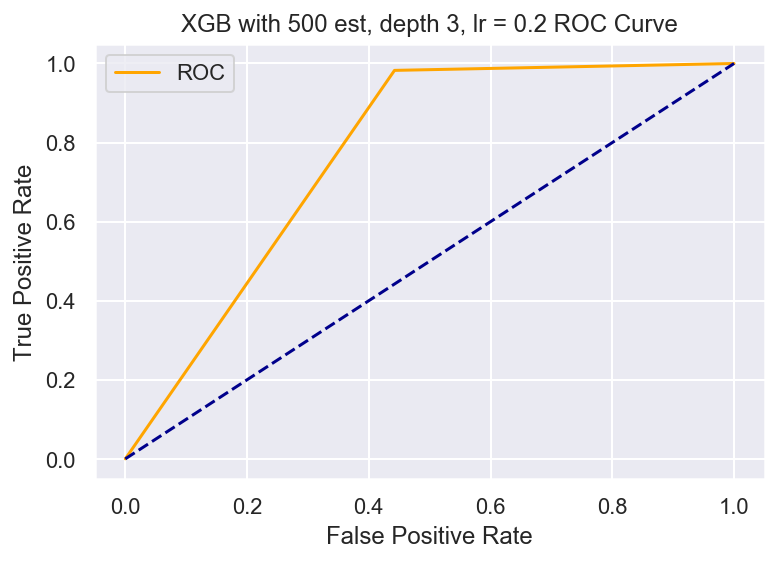

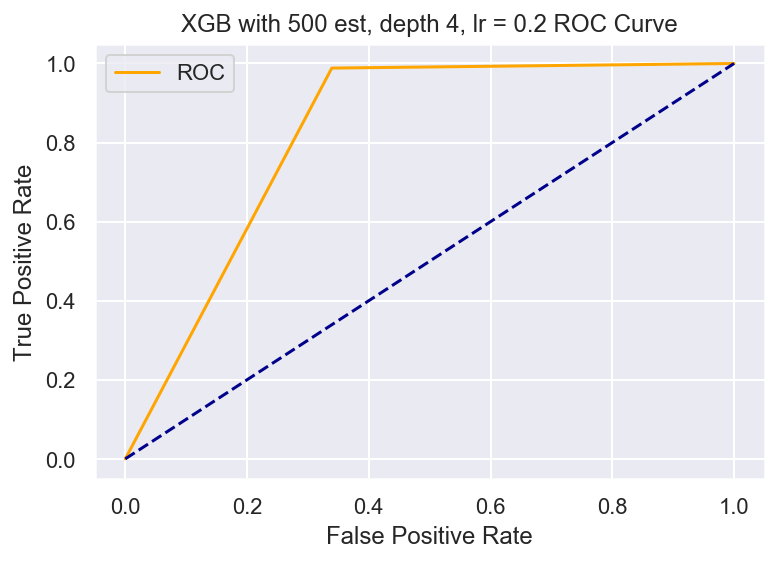

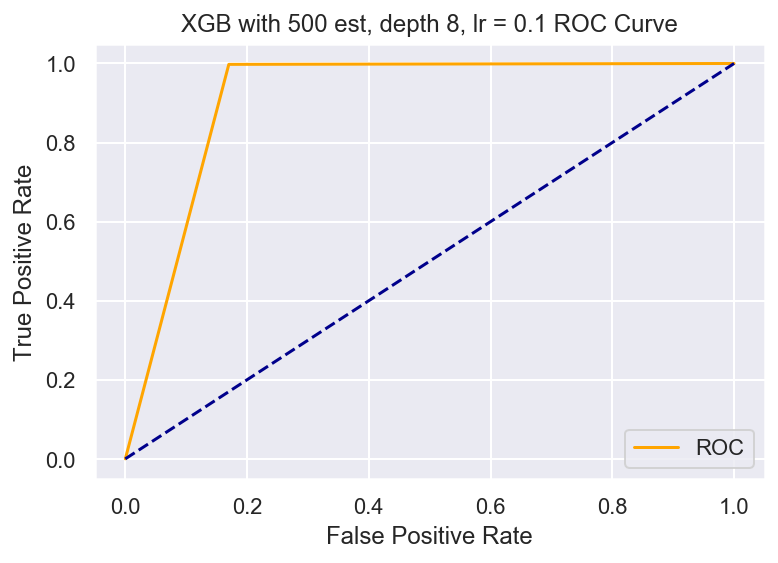

In [257]:
########################################
##          MODEL RUN TEMPLATE        ##
########################################

df = df_Xy
target = 'reordered'
features = ['user_id', 'product_id', 'aisle_id', 'department_id', 'prev_order_ct', 'dept_visits',
       'aisle_visits', 'avg_order_size', 'prod_hod_mean', 'prod_hod_var',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'prod_hod_delta', 'prod_hod_delta_w']

X_train, X_val, y_train, y_val = train_val_test_split(df, features, target, oversample=True)



n = 500
depth = 5

estimators = [
    [f'RF with {n} est, depth {depth}', RandomForestClassifier(n_estimators=n, max_depth=depth)],
    [f'XGB with {n} est, depth 2, lr = 0.2', xgb.XGBClassifier(n_estimators=n, max_depth=2, learning_rate=0.2, verbosity=1)],
    [f'XGB with {n} est, depth 2, lr = 0.3', xgb.XGBClassifier(n_estimators=n, max_depth=2, learning_rate=0.3, verbosity=1)],
    [f'XGB with {n} est, depth 3, lr = 0.2', xgb.XGBClassifier(n_estimators=n, max_depth=3, learning_rate=0.2, verbosity=1)],
    [f'XGB with {n} est, depth 4, lr = 0.2', xgb.XGBClassifier(n_estimators=n, max_depth=4, learning_rate=0.2, verbosity=1)],
    [f'XGB with {n} est, depth 8, lr = 0.1', xgb.XGBClassifier(n_estimators=n, max_depth=8, learning_rate=0.1, verbosity=1)]
    ]

CheckModelPerformance(estimators, X_train, X_val, y_train, y_val, print_baseline=False, thresh=0.25)

In [227]:
def topNpredictionScore(group, n_recs=10): 
    n_reordered = group['reordered'].sum()

    _ = group.sort_values('pred_proba', ascending=False)
    _ = _[:n_recs]

    n = min(n_reordered, n_recs)
    return sum(_['reordered']) / n

(pd.concat([pd.Series(model_pred_prob[:,1],name='pred_proba'),
           df_Xy['user_id'], y], axis=1).groupby('user_id').apply(topNpredictionScore)
).mean()
 
 
#  .sort_values('pred_proba', ascending=False)).head(10).reordered.sum()/10

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


0.5983714179183981

In [211]:
#  .sort_values('pred_proba', ascending=False)).head(10).reordered.sum()/10
def overall_user_pred_reorder_pct(reordered_col):
    return (sum(reordered_col) / len(reordered_col))

(pd.concat([pd.Series(model_pred_prob[:,1],name='pred_proba'),
           df_Xy['user_id'], y], axis=1)
 .groupby('user_id').agg({
#                           'pct_reordered': lambda x: x['reordered'].sum() / x['reordered'].count()
                          'reordered': ['sum', 'count', overall_user_pred_reorder_pct]
                         })
)['reordered']['overall_user_pred_reorder_pct'].mean()
 
 


0.13773835764975945

# Export Combined Models Results to Flask-Ready Dataframe

In [259]:
combined_model_preds = {}

# Export Model
for estimator in estimators:

    # Export Model Results
    X = df_Xy[features]
    reordered_index = df_Xy[['order_id_ref','product_id','reordered']]

    # Obtain predictions for all values:
    model_name = estimator[0]
    est = estimator[1]
    model_pred_prob = (est.predict_proba(X))
    model_pred_prob[:,0].shape
    model_pred_named = pd.DataFrame(model_pred_prob[:,1],columns = ['pred_prob'])
    merged_preds = pd.concat([X[['user_id','product_id','prev_order_ct']], model_pred_named], axis=1)

    # add back some reference columns
    order_id_ref = df_Xy.order_id_ref.astype(int).rename(index = 'order_id',inplace=True)
    merged_preds = pd.concat([merged_preds, order_id_ref], axis=1)

    add_to_cart_order = df_Xy.add_to_cart_order.rename(index = 'add_to_cart_order',inplace=True)
    merged_preds = pd.concat([merged_preds, add_to_cart_order], axis=1)

    # merged_preds = pd.merge(
    #     merged_preds,
    #     df_order_prods__train[['order_id','product_id','add_to_cart_order']],
    #     on=['order_id','product_id'], how='outer'
    # )
    merged_preds = pd.merge(merged_preds, df_prod_dir[['product_name','product_id']], on='product_id')
#     print(merged_preds.columns)

    merged_preds = pd.merge(merged_preds, reordered_index,
                            left_on=['order_id','product_id'],
                            right_on=['order_id_ref','product_id']
                           )

    merged_preds.add_to_cart_order = merged_preds.add_to_cart_order.apply(lambda x: np.NaN if x==-1 else x)
    merged_preds = merged_preds.sort_values(by=['user_id','add_to_cart_order','product_id'])
    
    combined_model_preds[model_name] = merged_preds
    


In [263]:
key = list(combined_model_preds.keys())[0]
combined_model_preds[key]

user_id  product_id  prev_order_ct  pred_prob  order_id  \
133          1         196             10   0.820397   1187899   
166          1       25133              8   0.821364   1187899   
238          1       38928              1   0.400657   1187899   
275          1       26405              2   0.677188   1187899   
162          1       39657              1   0.382526   1187899   
...        ...         ...            ...        ...       ...   
4882       499       44632              1   0.384358    188500   
19101      499       45936              1   0.394941    188500   
445        499       47209              2   0.650241    188500   
20261      499       48130              1   0.412506    188500   
11103      499       48493              1   0.384560    188500   

       add_to_cart_order                             product_name  \
133                  1.0                                     Soda   
166                  2.0                    Organic String Cheese   
238                  3.0                 0% Greek Strained Yogurt   
275                  4.0         XL Pick-A-Size Paper Towel Rolls   
162                  5.0                   Milk Chocolate Almonds   
...                  ...                                      ...   
4882                 NaN               Sparkling Water Grapefruit   
19101                NaN                      Organic White Onion   
445                  NaN                     Organic Hass Avocado   
20261                NaN                   Organic Red Grapefruit   
11103                NaN  Butter 2.0 Featuring Virgin Coconut Oil   

       order_id_ref  reordered  
133       1187899.0          1  
166       1187899.0          1  
238       1187899.0          1  
275       1187899.0          1  
162       1187899.0          1  
...             ...        ...  
4882       188500.0          0  
19101      188500.0          0  
445        188500.0          0  
20261      188500.0          0  
11103      188500.0          0  

[20275 rows x 9 columns]

In [137]:
# User Cart Prediction Precision

def EvaluateUserCartRelevance():
    X = df_Xy[features]
    reordered_index = df_Xy[['order_id_ref','product_id','reordered']]
    
    user_cart_priority = pd.concat(
        [df_Xy['user_id'],
         df_Xy['add_to_cart_order'].apply(lambda x: 0 if x < 0 else x)],
        axis=1
    )
    

    user_cart_priority['cart_confidences'] = np.multiply(
        np.ravel(df_Xy['add_to_cart_order'].transform(lambda x: 0 if x < 0 else 1)),
        np.ravel(model_pred_named)
    )

    def avg_usr_cart_recall(pred_prob):
        return sum(pred_prob) / len(pred_prob)

    def cart_confidence_score(cart_confidences):
        return (sum(cart_confidences) / len(cart_confidences)) * 100

    # Average Cart Confidence Precision:
    avg_user_cart_confidence = user_cart_priority.groupby('user_id').agg(
        {'cart_confidences': cart_confidence_score}
    ).mean().values
    print("Average % Cart Confidence (Highest Score 100), Per User:", avg_user_cart_confidence)
    
    for thresh in np.linspace(0, 1, 20):
        model_pred_thresh = (model_pred_named >= thresh).astype(int)
        
        user_cart_thresholded = pd.concat([user_cart_priority, model_pred_thresh],axis=1)

        # Average User Cart Precision:
        avg_user_cart_recall = user_cart_thresholded.groupby(by='user_id').agg(
            {'pred_prob': avg_usr_cart_recall}).mean().values
        print(f"Avg User Cart Recall % at thresh={thresh}, Per User:", avg_user_cart_recall)
    
EvaluateUserCartRelevance()

Average % Cart Confidence (Highest Score 100), Per User: [8.45301072]
Avg User Cart Recall % at thresh=0.0, Per User: [1.]
Avg User Cart Recall % at thresh=0.05263157894736842, Per User: [1.]
Avg User Cart Recall % at thresh=0.10526315789473684, Per User: [1.]
Avg User Cart Recall % at thresh=0.15789473684210525, Per User: [0.99356207]
Avg User Cart Recall % at thresh=0.21052631578947367, Per User: [0.94977277]
Avg User Cart Recall % at thresh=0.2631578947368421, Per User: [0.86748177]
Avg User Cart Recall % at thresh=0.3157894736842105, Per User: [0.76564038]
Avg User Cart Recall % at thresh=0.3684210526315789, Per User: [0.61275013]
Avg User Cart Recall % at thresh=0.42105263157894735, Per User: [0.40004063]
Avg User Cart Recall % at thresh=0.47368421052631576, Per User: [0.3501308]
Avg User Cart Recall % at thresh=0.5263157894736842, Per User: [0.31915047]
Avg User Cart Recall % at thresh=0.5789473684210527, Per User: [0.28477249]
Avg User Cart Recall % at thresh=0.631578947368421, 

In [109]:
np.multiply(np.ravel(df_Xy['add_to_cart_order'].transform(lambda x: -1 if x < 0 else 1)),
         np.ravel(model_pred_named))

array([-0.67059282, -0.37948072, -0.37799139, ..., -0.36024313,
       -0.36440796, -0.34944574])

In [47]:
pd.concat(
    [pd.concat(
    [pd.concat(
        [X[['user_id','product_id']],
         model_pred_named], axis=1
    ), add_to_cart_order],
    axis=1
    ), y
)

user_id  product_id  pred_prob  add_to_cart_order
6051       160       40022   0.801895                1.0
17776      452       22935   0.552595               -1.0
4619       123        4913   0.387183               -1.0
19027      476       34448   0.245226               -1.0
11021      280       39928   0.409855               -1.0
16843      430        5077   0.355723               -1.0
9995       255       38849   0.403289                2.0
14929      370       13838   0.214585               -1.0
19675      487       10243   0.253162               -1.0
13303      328       46049   0.800281               -1.0
8521       214       31793   0.277599               -1.0
14127      349       42461   0.360017               -1.0
3493        93       46585   0.291573               -1.0
7721       204       21839   0.236283               -1.0
4682       124        7862   0.416956               -1.0
8163       210       12616   0.174463               -1.0
1258        37        7863   0.270989               -1.0
15781      393       17200   0.347195               -1.0
3923       106       16797   0.723197                5.0
13051      327       10132   0.491456               -1.0
17700      449       39619   0.232106               -1.0
3688        97       36210   0.339971               -1.0
7877       204       38926   0.225008               -1.0
8055       209       22195   0.479143               -1.0
4401       115        9365   0.318493               -1.0
18435      466       19611   0.549486               -1.0
5761       148         132   0.331354               -1.0
17812      452         432   0.463575               -1.0
13092      327        3464   0.411926               -1.0
11006      280       44596   0.199482               -1.0
11031      280       37288   0.604385               -1.0
12690      323        2421   0.172438               -1.0
3335        90       19382   0.476808               -1.0
19645      487       11046   0.502552               -1.0
10752      267       11281   0.541831               -1.0
10257      261        5618   0.346155               29.0
3263        89       23094   0.745376                3.0
1190        37       48364   0.276691               -1.0
6655       173       16479   0.374537               -1.0
5503       143       43806   0.276047               -1.0
7349       191       32605   0.401673               -1.0
8806       219        8224   0.240110               -1.0
273          9         481   0.708692               -1.0
5083       140       20114   0.600784               -1.0
17796      452       43352   0.241554               -1.0
14786      363       16823   0.299993               -1.0
20273      499       38200   0.364408               -1.0
3801        99       28769   0.487393               -1.0
2672        71       40519   0.288841               -1.0
15770      393       16290   0.316863               -1.0

In [61]:
# Export Actual User Orders
# _ = pd.merge(pd.merge(df_order_prods__train, df_prod_dir), df_orders_log)
# _ = _[['user_id','product_id','product_name','add_to_cart_order']]
# actual_user_orders = _[_.user_id < 10]

with open('../flask/cart_completer_app/data/merged_user_orders.pkl', 'wb') as file:
    pickle.dump(merged_preds, file)

In [217]:
with open('../flask/cart_completer_app/data/merged_user_orders.pkl', 'rb') as file:
    merged_orders = pickle.load(file)

In [225]:
@interact(User=(1,500), Threshold=FloatSlider(min=0.00,max=1.00, step=0.01))
def filter_user_order(Threshold=0.5,User=1):

    filtered = merged_preds[merged_preds.user_id == User]
    filtered = filtered[filtered['pred_prob'] > Threshold].sort_values(['add_to_cart_order',"product_id"])

#     renamed = filtered[['product_name','order_prob','prev_order_ct','Predicted Reordered?']]
#     renamed.columns = ['Product','Order Probability','Prev Orders by User','Predicted Reordered?']
    
    styled = filtered.style.set_table_styles(
                [
                    {'selector': 'thead th',
                'props': [('background-color', 'AliceBlue')]},
                    {'selector': 'thead th',
                'props': [('background-color', 'AliceBlue')]},
                    ]).hide_index()
    
    return styled

interactive(children=(FloatSlider(value=0.0, description='Threshold', max=1.0, step=0.01), IntSlider(value=1, …

In [331]:
@interact(User=(1,500), OrderInd=(0,len(train_orders)-1))
def filter_actual_user_orders(OrderInd=0,User=1):
    
    order_id = train_orders[OrderInd]
    
#     filtered = df_order_prods__train[df_order_prods__train.Ord == User]
    filtered = df_order_prods__train[df_order_prods__train.order_id == order_id]
    filtered = pd.merge(filtered,
                        df_orders_log[['order_id','user_id']],
                        on='order_id')
    
    renamed = filtered[['user_id','order_id','product_id','add_to_cart_order','reordered']].sort_values('product_id')
#     renamed.columns = ['Product','Order Probability','Reordered?']
    
    styled = renamed.style.set_table_styles(
                [
                    {'selector': 'thead th',
                'props': [('background-color', 'AliceBlue')]},
                    {'selector': 'thead th',
                'props': [('background-color', 'AliceBlue')]},
                    ]).hide_index()
    
    return styled

interactive(children=(IntSlider(value=0, description='OrderInd', max=297), IntSlider(value=1, description='Use…

In [166]:
with open('../flask/cart_completer_app/data/model_preds.pkl', 'wb') as file:
    pickle.dump(merged_preds, file)

In [342]:
@interact(
#     User=(1,500),
    Threshold=FloatSlider(min=0.00,max=1.00,step=0.01),
    OrderInd=(0,len(train_orders)-1),
    show_reordered_only=False
)
def filter_user_candidates(OrderInd=0, show_reordered_only=False, Threshold=0.0):
    
    order_id = train_orders[OrderInd]
    
    filtered = merged_preds[merged_preds.order_id == order_id]
    
    filtered = filtered[filtered['pred_' + model_name] > Threshold]
        
    filtered = filtered.sort_values('product_id')
#     renamed = filtered[['reordered_in_order_id','product_id','add_to_cart_order','reordered']].sort_values('product_id')
#     renamed.columns = ['Product','Order Probability','Reordered?']
    
    if show_reordered_only:
        filtered = filtered[filtered['Reordered?'] == 1]
    else:
        pass
    
    styled = filtered.style.set_table_styles(
                [
                    {'selector': 'thead th',
                'props': [('background-color', 'AliceBlue')]},
                    {'selector': 'thead th',
                'props': [('background-color', 'AliceBlue')]},
                    ]).hide_index().bar(subset=['pred_' + model_name], color='#5fba7d')
#     styled = styled.style
    
    return styled

interactive(children=(IntSlider(value=0, description='OrderInd', max=297), Checkbox(value=False, description='…

In [148]:
features = ['user_id', 'product_id',
       'aisle_id', 'department_id', 'prev_order_ct', 'dept_visits',
       'aisle_visits', 'avg_order_size', 'prod_hod_mean', 'prod_hod_var',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'prod_hod_delta', 'prod_hod_delta_w']
X = df_Xy[features]

In [152]:
df = df_Xy
target = 'reordered'
features = ['user_id', 'product_id',
       'aisle_id', 'department_id', 'prev_order_ct', 'dept_visits',
       'aisle_visits', 'avg_order_size', 'prod_hod_mean', 'prod_hod_var',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'prod_hod_delta', 'prod_hod_delta_w']

X_train, X_val, y_train, y_val = train_val_test_split(df, features, target, train_and_val=True, oversample=False)

In [120]:
for thresh in np.linspace(0.2, 0.5, 10):
    print('––––– thresh =', thresh,"––––––")
    xgb_pred_train = (sample_xgb_model.predict_proba(X_train)[:,1] >= thresh).astype(bool)
    xgb_pred_val = (sample_xgb_model.predict_proba(X_val)[:,1] >= thresh).astype(bool)
    print(f"train precision = {precision_score(y_train, xgb_pred_train)}")
    print(f"val precision = {precision_score(y_val, xgb_pred_val)}")
    print("\n")

––––– thresh = 0.2 ––––––
train precision = 0.9488222245695574
val precision = 0.8662674650698603


––––– thresh = 0.23333333333333334 ––––––
train precision = 0.9610035305445598
val precision = 0.8793053545586107


––––– thresh = 0.26666666666666666 ––––––
train precision = 0.9694565862608602
val precision = 0.891301158867537


––––– thresh = 0.30000000000000004 ––––––
train precision = 0.9763056355632846
val precision = 0.90134994807892


––––– thresh = 0.33333333333333337 ––––––
train precision = 0.9818012897584435
val precision = 0.9093085902424424


––––– thresh = 0.3666666666666667 ––––––
train precision = 0.986545853926414
val precision = 0.9176861501283794


––––– thresh = 0.4 ––––––
train precision = 0.9893710761097038
val precision = 0.9256550883607556


––––– thresh = 0.43333333333333335 ––––––
train precision = 0.9917743182069118
val precision = 0.932903423921388


––––– thresh = 0.4666666666666667 ––––––
train precision = 0.9936936438568347
val precision = 0.93937519331889

In [578]:
########################################
##          MODEL RUN TEMPLATE        ##
########################################

df = df_Xy
target = 'reordered'
features = ['user_id', 'product_id',
       'aisle_id', 'department_id', 'prev_order_ct', 'dept_visits',
       'aisle_visits', 'avg_order_size', 'prod_hod_mean', 'prod_hod_var',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'prod_hod_delta', 'prod_hod_delta_w']

X_train, X_val, y_train, y_val = train_val_test_split(df, features, target, train_and_val=True)

estimators = [
#     ['RF with 2000 est, depth 2', RandomForestClassifier(n_estimators=2000, max_depth=2)],
#     ['RF with 2000 est, depth 3', RandomForestClassifier(n_estimators=2000, max_depth=3)],
    ['Logistic Regression', LogisticRegression(solver='lbfgs', max_iter=10000)]
    ]

CheckModelPerformance(estimators, X_train, X_val, y_train, y_val, print_baseline=True)

Testing 1 Models Against Baseline
features:
['user_id', 'product_id', 'aisle_id', 'department_id', 'prev_order_ct', 'dept_visits', 'aisle_visits', 'avg_order_size', 'prod_hod_mean', 'prod_hod_var', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'prod_hod_delta', 'prod_hod_delta_w']
.............................................

__________ BASELINE __________
Train Set precision=0.0649464812037851
Validation Set precision=0.0632852489530014
-------

__________ Logistic Regression __________
Train Set precision=0.4375
Validation Set precision=0.36363636363636365
-------



### User Scope - Order Predictions

In [5]:
_ = pd.merge(pd.merge(df_order_prods__train, df_prod_dir), df_orders_log)
_ = _[['user_id','product_id','product_name','add_to_cart_order']]
sample_user_orders = _[_.user_id < 10]

In [6]:
sample_user_orders.sort_values('add_to_cart_order')

user_id  product_id                                 product_name  \
1626        5       15349                     Organic Raw Agave Nectar   
588         8       15937                                      Shallot   
1219        1         196                                         Soda   
2814        7       12053            Panama Peach Antioxidant Infusion   
1053        9       27555             Organic Dried Granny Apple Chips   
...       ...         ...                                          ...   
265         2       48821                          Pistachio Ice Cream   
266         2       11913                           Shelled Pistachios   
248         2       45645          Dark Chocolate Nuts & Sea Salt Bars   
267         2        1757            Organic Cashew Carrot Ginger Soup   
268         2       21329  Organic Hearty Split Pea & Uncured Ham Soup   

      add_to_cart_order  
1626                  1  
588                   1  
1219                  1  
2814                  1  
1053                  1  
...                 ...  
265                  27  
266                  28  
248                  29  
267                  30  
268                  31  

[100 rows x 4 columns]

In [8]:
with open('../flask/data/sample_user_orders.pkl', 'wb') as file:
    pickle.dump(sample_user_orders, file)